In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from denmarf import DensityEstimate
from denmarf.utils import plot_corner

from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal

## Mock data

In [2]:
mu = np.array([0, 0])
sigma = np.array([[1, +0.25], [+0.25, 1]])

np.random.seed(42)
num_samples = 1000
samples = np.random.multivariate_normal(mu, sigma, num_samples)

In [3]:
pdf = multivariate_normal(mean=mu, cov=sigma)
log_density_true = np.log(pdf.pdf(samples))

## Kernel Density Estimation

In [ ]:
kde = KernelDensity(kernel='gaussian', bandwidth='scott').fit(samples) # Using sklearn's KDE with proper bandwidth

In [34]:
samples_kde = kde.sample(num_samples)
log_density_kde = kde.score_samples(samples)

## Normalizing Flow

In [35]:
nfde = DensityEstimate().fit(samples) # May take a few minutes to train, using default parameters
nfde.save("nfde_2dGauss.pkl")

current average log likelihood: -5.453:   0%|          | 2/1000 [00:00<05:54,  2.81it/s]

KeyboardInterrupt: 

In [36]:
import torch

nfde = torch.load("nfde_2dGauss.pkl", weights_only=False)

In [37]:
samples_nfde = nfde.sample(num_samples)
log_density_nfde = nfde.score_samples(samples)

## Diagnostics

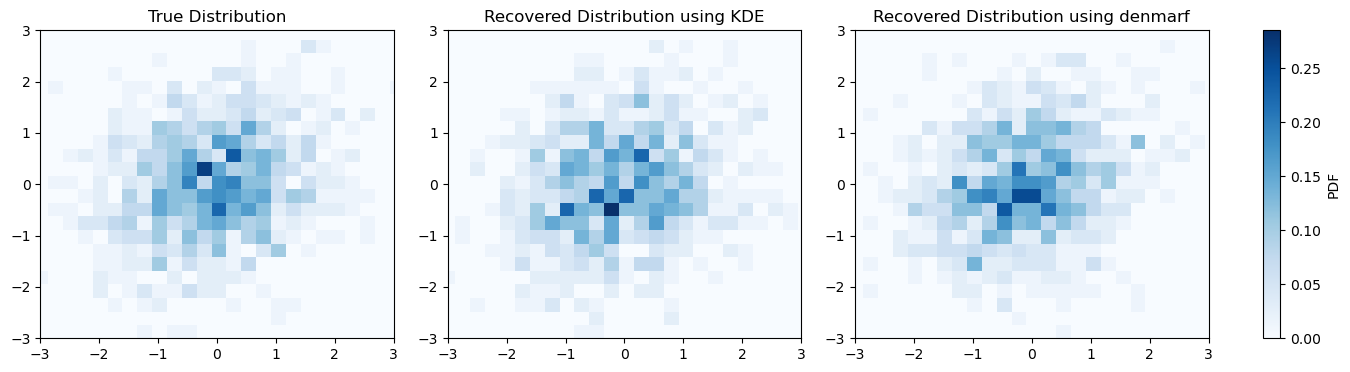

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), width_ratios=[20,20,20,1])

h1, xedges, yedges = np.histogram2d(samples[:,0], samples[:,1], bins=25, density=True)
h2, _, _ = np.histogram2d(samples_kde[:,0], samples_kde[:,1], bins=[xedges, yedges], density=True)
h3, _, _ = np.histogram2d(samples_nfde[:,0], samples_nfde[:,1], bins=[xedges, yedges], density=True)
vmin = min(h1.min(), h2.min(), h3.min())
vmax = max(h1.max(), h2.max(), h3.max())

# True Distribution
im = axs[0].pcolormesh(xedges, yedges, h1.T, vmin=vmin, vmax=vmax, cmap='Blues')
axs[0].set_xlim(-3, 3)
axs[0].set_ylim(-3, 3)
axs[0].set_title("True Distribution")

# KDE
axs[1].pcolormesh(xedges, yedges, h2.T, vmin=vmin, vmax=vmax, cmap='Blues')
axs[1].set_xlim(-3, 3)
axs[1].set_ylim(-3, 3)
axs[1].set_title("Recovered Distribution using KDE")

# denmarf
axs[2].pcolormesh(xedges, yedges, h3.T, vmin=vmin, vmax=vmax, cmap='Blues')
axs[2].set_xlim(-3, 3)
axs[2].set_ylim(-3, 3)
axs[2].set_title("Recovered Distribution using denmarf")

fig.colorbar(im, cax=axs[3], label="PDF")

# plt.tight_layout()
plt.show()

In [39]:
comparison_df = pd.DataFrame({
    "True Distribution": log_density_true[:3],
    "KDE": log_density_kde[:3],
    "denmarf": log_density_nfde[:3]
})

display(comparison_df)

,True Distribution,KDE,denmarf
0,-1.938529,-2.023698,-1.832661
1,-3.175168,-3.052158,-3.247574
2,-1.860432,-1.933076,-1.814898


In [40]:
def get_KL_divergence(p_log_density, q_log_density):
    p = np.exp(p_log_density) / np.sum(np.exp(p_log_density))
    q = np.exp(q_log_density) / np.sum(np.exp(q_log_density))
    return np.sum(p * np.log(p / q))

In [49]:
print("KL Divergence between True Distribution and KDE: ", get_KL_divergence(log_density_true, log_density_kde))
print("KL Divergence between True Distribution and NFDE:", get_KL_divergence(log_density_true, log_density_nfde))

KL Divergence between True Distribution and KDE:  0.0045463843547106815
KL Divergence between True Distribution and NFDE: 0.0031061615644443975


Removed no burn in
Removed no burn in


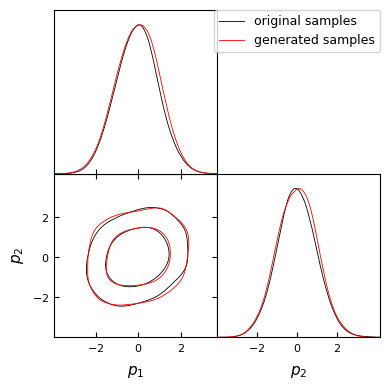

In [47]:
plot_corner(samples, kde) # Plot using KDE

Removed no burn in
Removed no burn in


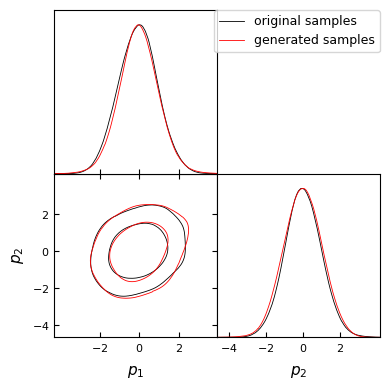

In [45]:
plot_corner(samples, nfde) # Plot using denmarf